 # **Aplicaciones Clásicas de IA en Visión por Computadora**
**Instalación de dependencias**:
```bash
!pip install datasets scikit-learn scikit-image opencv-python matplotlib numpy
```

In [3]:
from datasets import load_dataset
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## **1. Cargar Dataset (CIFAR-10)**

In [12]:
# Cargar dataset CIFAR-10 desde Hugging Face
dataset = load_dataset("cifar10")

# Convertir a numpy arrays
def process_dataset(batch):
    images = [np.array(img.convert('RGB')) for img in batch["img"]]  # Ensure RGB format
    return {
        "image": [img.astype(np.uint8) for img in images],  # Force uint8 conversion
        "label": batch["label"]
    }


dataset = dataset.map(process_dataset, batched=True)
train_images = np.array(dataset["train"]["image"])
train_labels = np.array(dataset["train"]["label"])
test_images = np.array(dataset["test"]["image"])
test_labels = np.array(dataset["test"]["label"])

Map: 100%|██████████| 10000/10000 [00:10<00:00, 981.95 examples/s]


## **2. Extracción de Características**

In [4]:
def extract_features(images, radius=3, n_points=24, pca_components=28):
    features = []
    for img in images:
        # Ensure correct dtype and color space
        img = np.array(img)
        if img.dtype != np.uint8:
            img = img.astype(np.uint8)

        # Convert to grayscale properly
        if len(img.shape) == 3:  # If color image (H, W, C)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        else:  # Already grayscale
            gray = img.copy()

        # 1. Normalización CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        normalized = clahe.apply(gray)

        # 2. LBP
        lbp = local_binary_pattern(normalized, n_points, radius, method='uniform')
        hist_lbp, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

        # 3. Haralick
        glcm = graycomatrix(normalized, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]

        # Combinar características
        features.append(np.concatenate([hist_lbp, [contrast, energy]]))

    # Aplicar PCA
    pca = PCA(n_components=pca_components)
    return pca.fit_transform(np.array(features))

## **3. Entrenamiento y Evaluación**

In [13]:
# Crear y entrenar MLP

# 4. Extraer características (¡Ejecutar esto primero!)
X_train = extract_features(train_images)
X_test = extract_features(test_images)
y_train = train_labels
y_test = test_labels

In [14]:

mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=500,
    alpha=0.001,
    learning_rate_init=0.001,
    verbose=True
)

mlp.fit(X_train, y_train)

# Evaluar
preds = mlp.predict(X_test)
print(classification_report(y_test, preds))

Iteration 1, loss = 4.63438018
Iteration 2, loss = 2.38432246
Iteration 3, loss = 2.32291749
Iteration 4, loss = 2.24624988
Iteration 5, loss = 2.29472978
Iteration 6, loss = 2.24688739
Iteration 7, loss = 2.19102662
Iteration 8, loss = 2.18450202
Iteration 9, loss = 2.18982457
Iteration 10, loss = 2.16928599
Iteration 11, loss = 2.18713241
Iteration 12, loss = 2.14399129
Iteration 13, loss = 2.13505456
Iteration 14, loss = 2.11512641
Iteration 15, loss = 2.18788935
Iteration 16, loss = 2.12585439
Iteration 17, loss = 2.14228277
Iteration 18, loss = 2.16426615
Iteration 19, loss = 2.08115293
Iteration 20, loss = 2.06524298
Iteration 21, loss = 2.06252876
Iteration 22, loss = 2.06133843
Iteration 23, loss = 2.07437659
Iteration 24, loss = 2.05108589
Iteration 25, loss = 2.03317579
Iteration 26, loss = 2.08417932
Iteration 27, loss = 2.03500854
Iteration 28, loss = 2.01025528
Iteration 29, loss = 2.02091709
Iteration 30, loss = 2.03222392
Iteration 31, loss = 2.01066915
Iteration 32, los

## **4. Ejemplo con Dataset Médico (skin cancer)**

In [5]:
dataset = load_dataset("marmal88/skin_cancer")  # 10,015 imágenes

def process_medical_images(batch):
    processed = []
    for img in batch["image"]:
        # Preprocesamiento específico para imágenes médicas
        img = np.array(img)
        gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (128, 128))
        processed.append(resized)
    return {"image": processed, "label": batch["dx"]}

skin_dataset = dataset.map(process_medical_images, batched=True)

# Extraer características y entrenar
X_medical = extract_features(skin_dataset["train"]["image"])
y_medical = skin_dataset["train"]["dx"]

X_train_med, X_test_med, y_train_med, y_test_med = train_test_split(X_medical, y_medical, test_size=0.2)

mlp_med = MLPClassifier(hidden_layer_sizes=(50, 25))
mlp_med.fit(X_train_med, y_train_med)
print(classification_report(y_test_med, mlp_med.predict(X_test_med)))

Map:   0%|          | 0/9577 [00:00<?, ? examples/s]C:\Users\Cosij\PycharmProjects\Artificial-intelligence-Course-2\venvold\lib\site-packages\datasets\features\image.py:347: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
Map: 100%|██████████| 1285/1285 [00:35<00:00, 36.07 examples/s]


                               precision    recall  f1-score   support

            actinic_keratoses       0.18      0.29      0.22        59
         basal_cell_carcinoma       0.18      0.08      0.11        91
benign_keratosis-like_lesions       0.24      0.29      0.26       198
               dermatofibroma       0.00      0.00      0.00        19
             melanocytic_Nevi       0.79      0.89      0.83      1323
                     melanoma       0.13      0.04      0.06       199
             vascular_lesions       0.00      0.00      0.00        27

                     accuracy                           0.66      1916
                    macro avg       0.22      0.22      0.21      1916
                 weighted avg       0.60      0.66      0.62      1916



## **5. Visualización de Características**

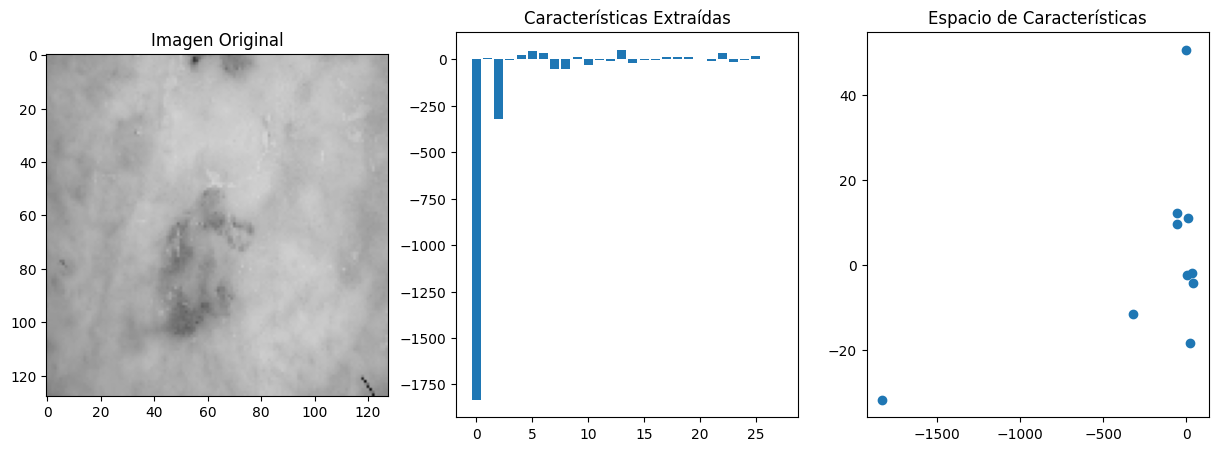

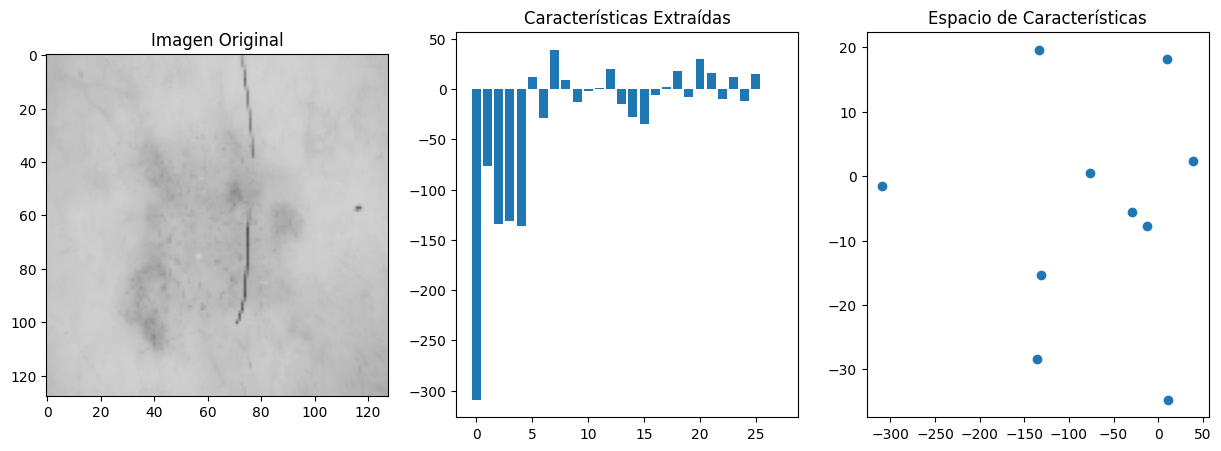

In [7]:
# Mostrar ejemplos
def plot_sample_features(idx):
    img = skin_dataset["train"]["image"][idx]
    features = X_medical[idx]
    
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Imagen Original')
    
    plt.subplot(132)
    plt.bar(range(len(features)), features)
    plt.title('Características Extraídas')
    
    plt.subplot(133)
    plt.scatter(features[:10], features[10:20])
    plt.title('Espacio de Características')
    plt.show()

plot_sample_features(0)
plot_sample_features(100)


## **6. Optimización de Hiperparámetros**

In [11]:
from sklearn.model_selection import GridSearchCV

# Configurar parámetros
parameters = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.001, 0.01]
}

# Búsqueda en grid
clf = GridSearchCV(MLPClassifier(max_iter=500), parameters, n_jobs=-1, cv=3)
clf.fit(X_train_med, y_train_med)

print(f"Mejores parámetros: {clf.best_params_}")
print(f"Mejor puntuación: {clf.best_score_:.2f}")

Mejores parámetros: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}
Mejor puntuación: 0.66


## **Referencias**
- CIFAR-10: https://huggingface.co/datasets/cifar10
- Scikit-learn: https://scikit-learn.org
- OpenCV: https://opencv.org